In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib

import pandas

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
import pydotplus 

from sklearn import metrics

import scipy
from scipy import sqrt

import seaborn as sns
sns.set_style("white")

import sys
sys.path.append('../../modules/')
from Processors import *

## Skim size, Acceptance, xSec and luminosity

In [2]:
from DataInfo import *

### Calculate FOM

In [3]:
from helper import *

## Get Data

In [4]:
loc = '../../../data_n/'

masses = [260, 270, 280, 300, 320, 400, 500, 550, 600, 700]
backgroundLabels = ['TT', 'WJets']

signalData = []
backgroundData = []

for mass in masses:
    signalData.append(pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + 
                                      str(mass) + "_narrow_13TeV-madgraph.csv"))

# same as 2 but only the first half of the events
#backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_1.csv"))
backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv"))
backgroundData.append(pandas.read_csv(loc + "WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv"))


# drop columns without header
for mass, signal_data in zip(masses, signalData):
    signal_data.drop([x for x in signal_data.columns if 'Unnamed' in x], axis=1, inplace=True)
    signal_data['gen_label'] = str(mass)

for label, background_data in zip(backgroundLabels, backgroundData):
    background_data.drop([x for x in background_data.columns if 'Unnamed' in x], axis=1, inplace=True)
    background_data['gen_label'] = label

allSignalData = mergeDataFrame(signalData)
allBackgroundData = mergeDataFrame(backgroundData)

for i in range(len(masses)):
    print("{} events for Higgs with {} GeV".format(len(signalData[i]), masses[i]))
print("{} TT_Tune events".format(len(backgroundData[0])))
print("{} WJetsToLNu_Tune events".format(len(backgroundData[1])), end='\n\n')
print("{} events of Higgs".format(len(allSignalData)))
print("{} background events".format(len(allBackgroundData)))

403 events for Higgs with 260 GeV
394 events for Higgs with 270 GeV
390 events for Higgs with 280 GeV
372 events for Higgs with 300 GeV
479 events for Higgs with 320 GeV
655 events for Higgs with 400 GeV
1619 events for Higgs with 500 GeV
1858 events for Higgs with 550 GeV
2008 events for Higgs with 600 GeV
2239 events for Higgs with 700 GeV
166157 TT_Tune events
1896 WJetsToLNu_Tune events

10417 events of Higgs
168053 background events


In [5]:
dropMctMatch = True
mIdx = 5

if dropMctMatch:
    # drop signal that does not match thing
    allSignalData = allSignalData[allSignalData['gen_mctMatch']]
    signalData = list(map(lambda x: x[x['gen_mctMatch']], signalData))
    #for signal_data in signalData:
    #    signal_data = signal_data[signal_data['gen_mctMatch']]

signalSizes = list(map(len, signalData))

allData = allSignalData.append(allBackgroundData, ignore_index=True)
allLabels = np.append(np.full(sum(signalSizes[:mIdx]), fill_value=2), np.append(np.ones(sum(signalSizes[mIdx:])),np.zeros(len(allBackgroundData))))

In [6]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH']

for p in particles:
    moveToCartesian(allData, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    addEnergy(allData, p) #Calculate energy and absolute momentum
    
moveToCartesian(allData, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(allData, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(allData, allData['t_1_pT'], allData['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu

## select train variables

In [7]:
genFeatures = [var for var in allData.columns if str.startswith(var, "gen")] #Generator features; not for training
trainFeatures = [var for var in allData.columns if var not in genFeatures] #Reconstructed features; ok for training

In [8]:
pTEtaPhi = [var for var in trainFeatures for x in ['phi', 't_1_mass'] if x in var] # 'pT', 'eta', 
other = [var for var in trainFeatures for x in ['diH_kinFit_prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi]# + other]

In [9]:
fsFeatures = [var for var in trainFeatures for p in particles + ['mPT'] if p in var]
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']

In [10]:
classTrainFeatures = [x for x in allData.columns if x not in genFeatures]

# minimalistic:
#classTrainFeatures = ['b_0_eta', 'b_0_mass', 'b_0_csv'] + \
#                     ['b_1_eta', 'b_1_mass', 'b_1_csv'] + \
#                     ['mPT_pT'] + \
#                     ['h_tt_svFit_mass', 'h_tt_mass'] + \
#                     ['h_bb_mass'] + \
#                     ['diH_mass', 'diH_kinFit_mass', 'diH_kinFit_prob']
print("Training on {} features {}". format(len(classTrainFeatures), classTrainFeatures))

Training on 91 features ['t_0_pT', 't_0_eta', 't_0_phi', 't_0_mass', 't_1_pT', 't_1_eta', 't_1_phi', 't_1_mass', 'b_0_pT', 'b_0_eta', 'b_0_phi', 'b_0_mass', 'b_0_csv', 'b_1_pT', 'b_1_eta', 'b_1_phi', 'b_1_mass', 'b_1_csv', 'mPT_pT', 'mPT_phi', 'h_tt_pT', 'h_tt_eta', 'h_tt_phi', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_pT', 'h_bb_eta', 'h_bb_phi', 'h_bb_mass', 'diH_pT', 'diH_eta', 'diH_phi', 'diH_mass', 'diH_kinFit_mass', 'diH_kinFit_prob', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'd

In [11]:
removeFromTrain = []

allDataTrainFeatures = allData

for remove in removeFromTrain:
    allLabels = allLabels[allDataTrainFeatures['gen_label'] != str(remove)]
    allDataTrainFeatures = allDataTrainFeatures[allDataTrainFeatures['gen_label'] != str(remove)]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(allDataTrainFeatures, allLabels, test_size=0.2, random_state=2345)

allDataTrainFeatures = allDataTrainFeatures[classTrainFeatures]

X_train, X_test, y_train, y_test = train_test_split(allDataTrainFeatures, np.copy(allLabels), test_size=0.2, random_state=2345)
for var in (X_train, X_test, X_train_full, X_test_full):
    var.reset_index(inplace=True, drop=True)

## Remove points who fail conversion to float32

In [12]:
def cleanData(X, y):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    temp = X[classTrainFeatures]
    over  = (temp > np.finfo(np.float32).max)
    under = (temp < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)
    
    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    y = y[np.logical_not(selecting)]#.astype('float32')
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X, y

In [13]:
X_train, y_train = cleanData(X_train, y_train)
X_test , y_test  = cleanData(X_test , y_test )
X_train_full, y_train_full = cleanData(X_train_full, y_train_full)
X_test_full , y_test_full  = cleanData(X_test_full , y_test_full )

In [14]:
scale1 = len(allBackgroundData)/len(y_train[y_train==1])
scale2 = len(allBackgroundData)/len(y_train[y_train==2])

weights_train = np.ones(len(y_train))
weights_test = np.ones(len(y_test))

weights_train[y_train == 1] = scale1
weights_test[y_test == 1] = scale2
weights_train[y_train == 2] = scale1
weights_test[y_test == 2] = scale2

In [15]:
%%time
# fit model on training data
model = xgb.XGBClassifier(random_state=1337, silent=False,
                          #scale_pos_weight=scale,
                          objective='multi:softmax',
                          num_class=3,
                          n_estimators=100, eval_metric='mlogloss',
                          max_depth=4,
                          n_jobs=8) #NOTE: number of threads to execute
model.fit(X_train, y_train, sample_weight=weights_train)

CPU times: user 13min 16s, sys: 1.12 s, total: 13min 17s
Wall time: 1min 52s


In [16]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [17]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy           : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=y_test)
print("Accuracy signal    : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=np.logical_not(y_test))
print("Accuracy background: {:10}%".format(accuracy * 100.0))

Accuracy           : 96.13183000867302%
Accuracy signal    : 92.47910863509749%
Accuracy background: 96.16595390829175%


In [18]:
print(model.score(X_train, y_train, sample_weight=weights_train))
print(model.score(X_test, y_test, sample_weight=weights_test))

0.981676248336
0.950529030228


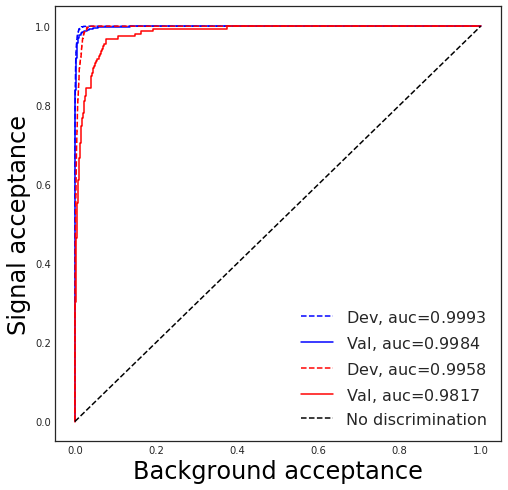

In [19]:
plt.figure(figsize=[8, 8])

y_train_bkg = y_train==0
y_test_bkg = y_test==0
y_train_sig1 = y_train==1
y_test_sig1 = y_test==1
y_train_sig2 = y_train==2
y_test_sig2 = y_test==2

train1 = y_train_bkg|y_train_sig1
test1 = y_test_bkg|y_test_sig1

train2 = y_train_bkg|y_train_sig2
test2 = y_test_bkg|y_test_sig2

y_train_bool = y_train.astype(bool)
y_test_bool = y_test.astype(bool)

plt.plot(*metrics.roc_curve(y_train_bool[train1], model.predict_proba(X_train)[:,1][train1])[:2],
         label=r'Dev, auc=${:.4f}$'.format(metrics.roc_auc_score(y_train_bool[train1], model.predict_proba(X_train)[:,1][train1])),
         color='b', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test_bool[test1], model.predict_proba(X_test)[:,1][test1])[:2], 
         label=r'Val, auc=${:.4f}$'.format(metrics.roc_auc_score(y_test_bool[test1], model.predict_proba(X_test)[:,1][test1])),
         color='b')

plt.plot(*metrics.roc_curve(y_train_bool[train2], model.predict_proba(X_train)[:,2][train2])[:2],
         label=r'Dev, auc=${:.4f}$'.format(metrics.roc_auc_score(y_train_bool[train2], model.predict_proba(X_train)[:,2][train2])),
         color='r', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test_bool[test2], model.predict_proba(X_test)[:,2][test2])[:2], 
         label=r'Val, auc=${:.4f}$'.format(metrics.roc_auc_score(y_test_bool[test2], model.predict_proba(X_test)[:,2][test2])),
         color='r')

plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

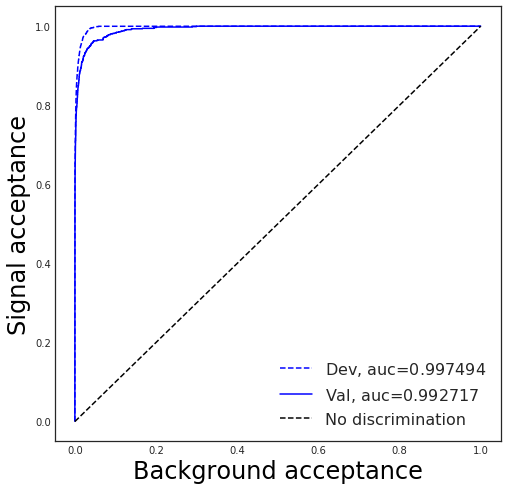

In [48]:
plt.figure(figsize=[8, 8])

y_train_bool = y_train.astype(bool)
y_test_bool = y_test.astype(bool)

plt.plot(*metrics.roc_curve(y_train_bool, 1.-model.predict_proba(X_train)[:,0])[:2],
         label=r'Dev, auc=${:.6f}$'.format(1.-metrics.roc_auc_score(y_train_bool, model.predict_proba(X_train)[:,0])),
         color='b', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test_bool, 1.-model.predict_proba(X_test)[:,0])[:2], 
         label=r'Val, auc=${:.6f}$'.format(1.-metrics.roc_auc_score(y_test_bool, model.predict_proba(X_test)[:,0])),
         color='b')

plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

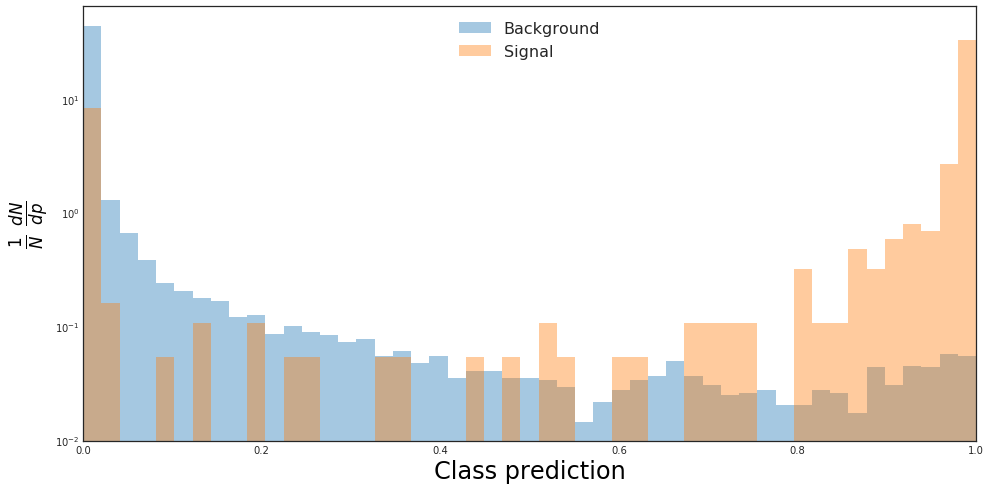

In [20]:
# WRONG!!!
params = {'hist' : True, 'kde' : False, 'norm_hist' : True, 'bins' : np.linspace(0, 1, 50)}
plt.figure(figsize=(16, 8))
a, b = y_test, model.predict_proba(X_test)[:,1]
signalThing, backgroundThing = b[a.astype(bool)], b[np.logical_not(a.astype(bool))]
sns.distplot(backgroundThing, label='Background', **params)
sns.distplot(signalThing, label='Signal', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Class prediction", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
plt.xlim([0,1])
plt.yscale('log', nonposy='clip')
plt.show()

In [21]:
backgroundTestData, signalTestData = [], []
backgroundScore, signalScore = [], []

for label in backgroundLabels:
    selection = X_test_full['gen_label'] == label
    var = X_test[selection]
    
    backgroundTestData.append(var)
    backgroundScore.append(model.predict_proba(var[classTrainFeatures])[:,1])
    
trainMasses = masses[:]
for mass in removeFromTrain: trainMasses.remove(mass)
    
for mass in trainMasses:
    selection = X_test_full['gen_label'] == str(mass)
    var = X_test[selection]
    
    signalTestData.append(var)
    
    col = 2 if mass < masses[mIdx] else 1
    
    signalScore.append(model.predict_proba(var[classTrainFeatures])[:,col])
    print(mass, np.average(model.predict_proba(var[classTrainFeatures])[:,col]))
    
for mass in removeFromTrain:
    selection = allData['gen_label'] == str(mass)
    var = allData[selection][classTrainFeatures]
    
    col = 2 if mass < masses[mIdx] else 1
    
    signalTestData.append(var)
    signalScore.append(model.predict_proba(var[classTrainFeatures])[:,col])
    print(mass, np.average(model.predict_proba(var[classTrainFeatures])[:,col]))
    
var = sorted(zip(trainMasses + removeFromTrain, signalTestData, signalScore))
signalTestData, signalScore = [i[1] for i in var], [i[2] for i in var]

260 0.803547
270 0.825718
280 0.729736
300 0.75147
320 0.594634
400 0.816783
500 0.966089
550 0.979142
600 0.986735
700 0.984514


In [22]:
def FOMAfterCut(p):
    cutSignal, cutBackground = [], []
    for mass, data, scores in zip(masses, signalTestData, signalScore):
        #NOTE: since this is using only the test data this must be divided by test_size
        cutSignal.append(np.sum(scores > p) / (.2 if mass not in removeFromTrain else 1))
    for data, scores in zip(backgroundTestData, backgroundScore):
        cutBackground.append(np.sum(scores > p) / .2)

    return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)))

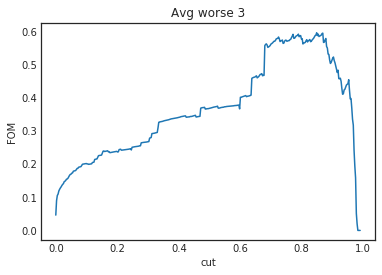

In [23]:
x = np.linspace(0,.99,400)
y = []
for i in x:
    y.append(FOMAfterCut(i))

plt.xlabel('cut')
plt.ylabel('FOM')
plt.title('Avg worse 3')
plt.plot(x, y)
plt.show()

In [24]:
def FOMAfterCutWorse(p):
    cutSignal, cutBackground = [], []
    for mass, data, scores in zip(masses, signalTestData, signalScore):
        #NOTE: since this is using only the test data this must be divided by test_size
        cutSignal.append(np.sum(scores > p) / (.2 if mass not in removeFromTrain else 1))
    for data, scores in zip(backgroundTestData, backgroundScore):
        cutBackground.append(np.sum(scores > p)/.2)

    return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)), min)

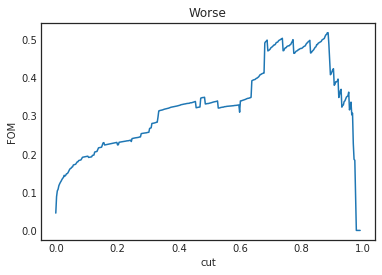

In [25]:
x = np.linspace(0,.99,400)
y = []
for i in x:
    y.append(FOMAfterCutWorse(i))

plt.xlabel('cut')
plt.ylabel('FOM')
plt.title('Worse')
plt.plot(x, y)
plt.show()

In [26]:
def FOMAfterCutForMass(p, a):
    cutSignal, cutBackground = [], []
    for mass, data, scores in zip(masses, signalTestData, signalScore):
        #NOTE: since this is using only the test data this must be divided by test_size
        cutSignal.append(np.sum(scores > p) / (.2 if mass not in removeFromTrain else 1))
    for data, scores in zip(backgroundTestData, backgroundScore):
        cutBackground.append(np.sum(scores > p) / .2)

    return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)), lambda x: x[a])

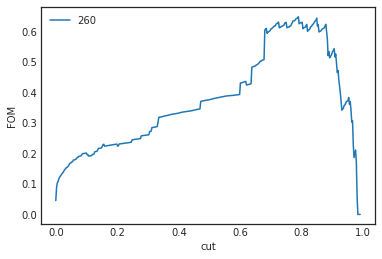

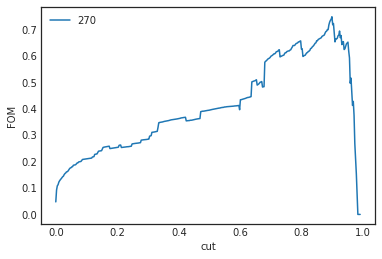

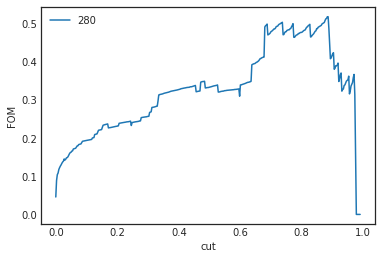

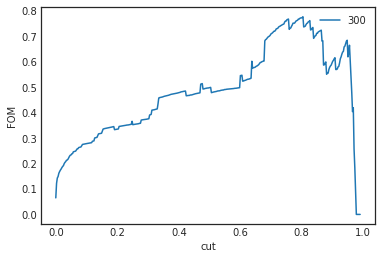

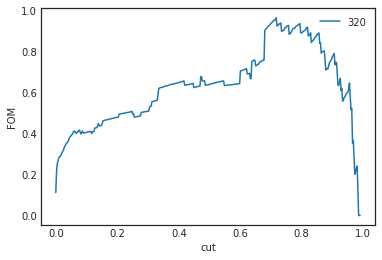

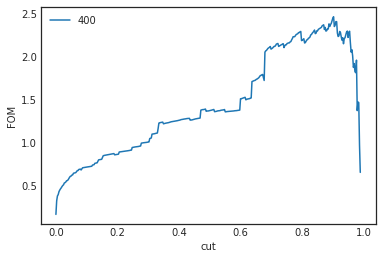

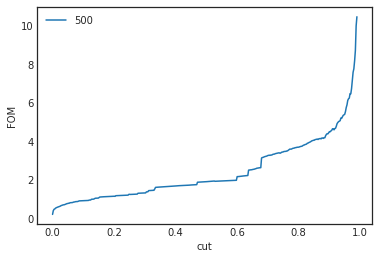

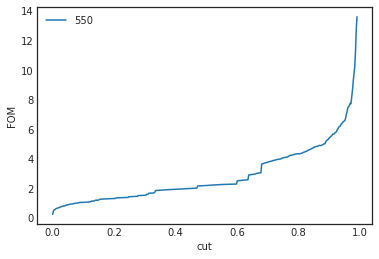

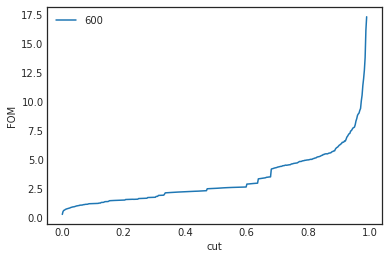

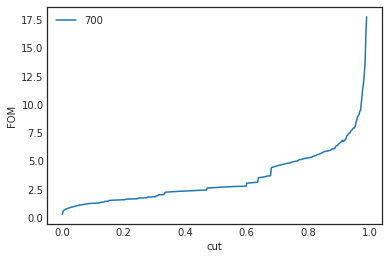

In [27]:
for j, mass in enumerate(masses):
    x = np.linspace(0,.99,400)
    y = []
    for i in x:
        y.append(FOMAfterCutForMass(i, j))

    plt.xlabel('cut')
    plt.ylabel('FOM')

    plt.plot(x, y, label=mass)
    plt.legend()#loc='best', fontsize=16)
    plt.show()

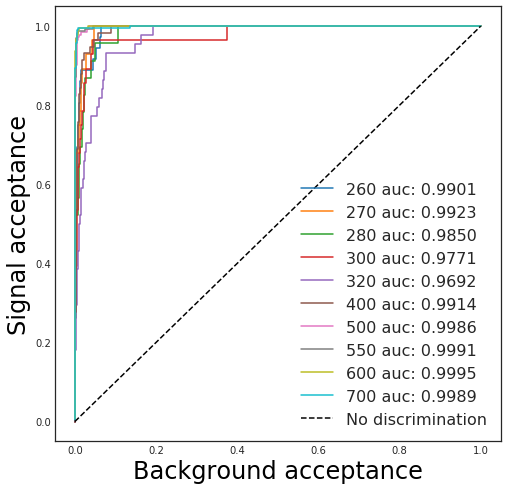

In [28]:
plt.figure(figsize=[8, 8])

for mass, signal in zip(masses, signalTestData):
    signalAndBackground = mergeDataFrame(backgroundTestData + [signal])
    backgroundSize = sum([len(i) for i in backgroundTestData])
    signalAndBackgroundLabel = np.append(np.zeros(backgroundSize, dtype=int), np.ones(len(signal), dtype=int))
    
    col = 2 if mass < masses[mIdx] else 1
    
    plt.plot(*metrics.roc_curve(signalAndBackgroundLabel, model.predict_proba(signalAndBackground)[:,col])[:2],
             label=str(mass) + ' auc: {:.4f}'.format(
             metrics.roc_auc_score(signalAndBackgroundLabel, model.predict_proba(signalAndBackground)[:,col])))

plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
#plt.xlim(0.,0.4)
#plt.ylim(0.6,1.)
plt.show()

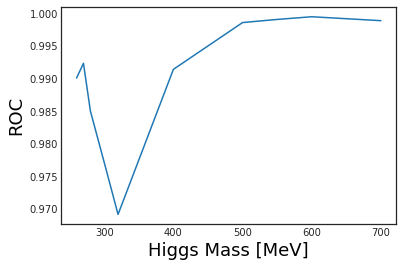

In [29]:
x,y = [], []
for mass, signal in zip(masses, signalTestData):
    signalAndBackground = mergeDataFrame(backgroundTestData + [signal])
    backgroundSize = sum([len(i) for i in backgroundTestData])
    signalAndBackgroundLabel = np.append(np.zeros(backgroundSize, dtype=int), np.ones(len(signal), dtype=int))
    
    col = 2 if mass < masses[mIdx] else 1
    
    x.append(mass)
    y.append(metrics.roc_auc_score(signalAndBackgroundLabel, model.predict_proba(signalAndBackground)[:,col]))
plt.plot(x,y)
plt.xlabel('Higgs Mass [MeV]', color='black', fontSize=18)
plt.ylabel('ROC', color='black', fontSize=18)
plt.show()

In [30]:
featureInportance = sorted(zip(classTrainFeatures,model.feature_importances_), key= lambda x: x[1], reverse=True)
print(*featureInportance, sep='\n')
print(len(featureInportance))

('diH_kinFit_mass', 0.12130906)
('diH_kinFit_prob', 0.1031004)
('h_tt_svFit_mass', 0.095964566)
('h_tt_pT', 0.056102362)
('t_0_pT', 0.055364173)
('h_tt_phi', 0.048474409)
('h_bb_mass', 0.039124016)
('mT', 0.036663387)
('diH_mass', 0.035925198)
('b_1_csv', 0.030757874)
('h_tt_mass', 0.02214567)
('h_bb_pT', 0.020669291)
('b_0_csv', 0.017716536)
('h_bb_pz', 0.017470472)
('b_1_pT', 0.016732283)
('t_1_pT', 0.015009843)
('mPT_pT', 0.013041339)
('t_0_mass', 0.0095964568)
('hT', 0.009104331)
('t_1_phi', 0.0076279528)
('spherocityEigen1', 0.0076279528)
('t_0_px', 0.0076279528)
('b_1_eta', 0.00738189)
('diH_py', 0.0066437009)
('b_0_mass', 0.006397638)
('sphericityEigen1', 0.006397638)
('t_0_eta', 0.0061515747)
('sT', 0.0061515747)
('mPT_phi', 0.0059055118)
('t_0_|p|', 0.0059055118)
('b_1_px', 0.0059055118)
('t_1_py', 0.0056594489)
('t_1_|p|', 0.0056594489)
('h_tt_|p|', 0.0056594489)
('diH_phi', 0.005413386)
('h_bb_py', 0.005413386)
('spherocity', 0.0051673227)
('t_1_px', 0.0049212598)
('mPT_px',

In [31]:
values = {'thresh':[], 'n':[], 'test':[], 'train':[]}

In [32]:
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

thresholds = sort(list(set(model.feature_importances_)))

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier(random_state=1337, silent=False,
                          #scale_pos_weight=scale,
                          objective='binary:logistic',
                          n_estimators=100, eval_metric='auc',
                          max_depth=4,
                          n_jobs=8) #NOTE: number of threads to execute
    selection_model.fit(select_X_train, y_train, sample_weight=weights_train)
    # eval model
    select_X_test = selection.transform(X_test)

    accuracy = metrics.roc_auc_score(y_train_bool[train1], selection_model.predict_proba(select_X_train)[:,1][train1]) + \
               metrics.roc_auc_score(y_train_bool[train2], selection_model.predict_proba(select_X_train)[:,2][train2])
    values['train'].append(accuracy)
    accuracy = metrics.roc_auc_score(y_test_bool[test1], selection_model.predict_proba(select_X_test)[:,1][test1]) + \
               metrics.roc_auc_score(y_test_bool[test2], selection_model.predict_proba(select_X_test)[:,2][test2])
    values['test'].append(accuracy)
    values['n'].append(select_X_train.shape[1])
    values['thresh'].append(thresh)
    print("Thresh=%.4f, n=%d, Accuracy: %.10f" % (thresh, select_X_train.shape[1], accuracy))

Thresh=0.0000, n=91, Accuracy: 1.9801258693
Thresh=0.0005, n=83, Accuracy: 1.9801258693
Thresh=0.0010, n=81, Accuracy: 1.9801268460
Thresh=0.0012, n=78, Accuracy: 1.9802145023
Thresh=0.0015, n=76, Accuracy: 1.9800022583
Thresh=0.0017, n=73, Accuracy: 1.9798299298
Thresh=0.0020, n=71, Accuracy: 1.9796974422
Thresh=0.0022, n=69, Accuracy: 1.9798010466
Thresh=0.0025, n=65, Accuracy: 1.9792125038
Thresh=0.0027, n=61, Accuracy: 1.9796103396
Thresh=0.0030, n=57, Accuracy: 1.9794030247
Thresh=0.0032, n=55, Accuracy: 1.9795467719
Thresh=0.0034, n=52, Accuracy: 1.9797390218
Thresh=0.0037, n=47, Accuracy: 1.9794350906
Thresh=0.0039, n=45, Accuracy: 1.9803135216
Thresh=0.0042, n=44, Accuracy: 1.9800839523
Thresh=0.0047, n=40, Accuracy: 1.9798490450
Thresh=0.0049, n=39, Accuracy: 1.9799981506
Thresh=0.0052, n=37, Accuracy: 1.9794252827
Thresh=0.0054, n=36, Accuracy: 1.9797877578
Thresh=0.0057, n=34, Accuracy: 1.9798914688
Thresh=0.0059, n=31, Accuracy: 1.9795590338
Thresh=0.0062, n=28, Accuracy: 1

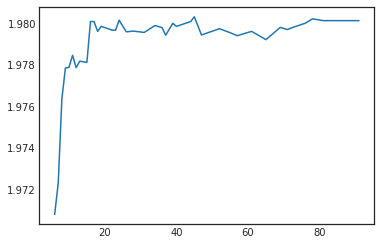

In [33]:
plt.plot(values['n'][:-5], values['test'][:-5])
plt.show()

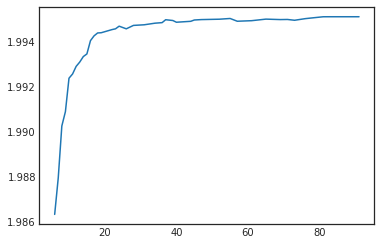

In [34]:
plt.plot(values['n'][:-5], values['train'][:-5])
plt.show()